In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import mahakala as ma

from mahakala.grmhd.athenak import AthenakFluidModel

gpu


In [4]:
fname = '../data/torus.mhd_w_bcc.01500.athdf'

In [5]:
bhspin = 0.9
fluid_model = AthenakFluidModel(fname, bhspin)

100%|██████████| 456/456 [00:00<00:00, 461.94it/s]


In [21]:
bhspin = 0.9
inclination_in_degrees = 60
distance_in_rg = 1000

fov = 10
number_pixels_across = 160

s0 = ma.initialize_geodesics_at_camera(bhspin, inclination_in_degrees, distance_in_rg, -fov, fov, number_pixels_across)

In [23]:
S, final_dt = ma.geodesic_integrator(10000, s0, 40, 1e-4, bhspin)

In [18]:
512*512 * 1000 * (4 + 4) * 4 / 1.e9

8.388608

In [ ]:
## scratch space

In [ ]:
## end scratch

In [13]:
primitive_data = fluid_model.get_prims_from_geodesics(S)

100%|██████████| 456/456 [12:41<00:00,  1.67s/it]


In [14]:
tensorial_data = fluid_model.compute_tensorial(S, primitive_data)

100%|██████████| 10001/10001 [00:05<00:00, 1787.38it/s]
/home/george/sites/liamedeiros/Mahakala/mahakala/grmhd/athenak.py:720: RuntimeWarning: invalid value encountered in divide
  angle = KuBu/(np.abs(KuUu) * np.sqrt(BuBu))


In [15]:
local_nu = -tensorial_data['kdotu'] * 230e9
gamma_inv_data = local_nu / 230.e9

fluid_params = dict()
fluid_params['fluid_gamma'] = 13./9

beta_data = primitive_data['u']/tensorial_data['bdotb'] * (((fluid_params['fluid_gamma']) - 1)/0.5)
index = np.where(np.isnan(beta_data) == True)
beta_data[index[0],index[1]] = 0

/tmp/ipykernel_9917/2893603202.py:7: RuntimeWarning: invalid value encountered in divide
  beta_data = primitive_data['u']/tensorial_data['bdotb'] * (((fluid_params['fluid_gamma']) - 1)/0.5)


In [16]:
KB = 1.3807e-16
CL = 2.99792458e10
ME = 9.1094e-28
MP = 1.6726e-24
EC = 4.8032e-10
HPL = 6.6261e-27
GNEWT = 6.6743e-8

In [17]:
Mass_scale = 5e+24
M_BH = 6.2e9 * 1.989e33

R_high = 40

bfield = np.sqrt(tensorial_data['bdotb']) * CL * np.sqrt(np.power(GNEWT*M_BH/CL**2,-3) * Mass_scale * 4 * np.pi)
ne_data = Mass_scale * primitive_data['dens'] * pow(GNEWT*M_BH/CL**2,-3) * 1/(1.67 * 1e-24 +  9.1094 * 1e-28)

R_imp = ((R_high * (beta_data)**2/(1 + (beta_data)**2)) + 1/(1+(beta_data)**2))
t_electron = CL**2 * (MP  * primitive_data['u'] * (4/3 -1) * (5/3-1))/(KB * primitive_data['dens'] * ((5/3-1) + (4/3-1) * R_imp))
thetae = KB * t_electron/(ME*CL*CL)

del R_imp

/tmp/ipykernel_9917/2118307643.py:10: RuntimeWarning: invalid value encountered in divide
  t_electron = CL**2 * (MP  * primitive_data['u'] * (4/3 -1) * (5/3-1))/(KB * primitive_data['dens'] * ((5/3-1) + (4/3-1) * R_imp))


In [18]:
import mahakala.transfer

from tqdm import tqdm

In [19]:
nsteps, npx, _ = S.shape

synemiss_data = np.empty((nsteps, npx))
for i in tqdm(range(nsteps)):
    synemiss_data[i] = mahakala.transfer.emission_coefficient(ne_data[i], t_electron[i], bfield[i], local_nu[i], beta_data[i], tensorial_data['pitch_angle'][i])
index = np.where(np.isnan(synemiss_data) == True)  # is the == True needed?
synemiss_data[index[0], index[1]] = 0.0
del index

absorption_data = np.zeros((nsteps, npx))
for i in tqdm(range(nsteps)):
    absorption_data[i] = mahakala.transfer.absorption_coefficient(t_electron[i,:], synemiss_data[i,:], local_nu[i,:], beta_data[i,:])
index = np.where(np.isnan(absorption_data) == True)
absorption_data[index[0], index[1]] = 0.0
del index

  0%|          | 0/10001 [00:00<?, ?it/s]

  3%|▎         | 318/10001 [00:00<00:15, 629.66it/s]/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:56: RuntimeWarning: invalid value encountered in power
  var = np.exp(-np.power(X,1./3.))
/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:57: RuntimeWarning: invalid value encountered in power
  synemiss = Ne*nus*np.power(jnp.sqrt(X)+np.power(2., 11./12.)*np.power(X,1./6.),2.)/(special.kn(2,1./thetae))
/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:54: RuntimeWarning: divide by zero encountered in divide
  X=nu/nus
/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:57: RuntimeWarning: invalid value encountered in multiply
  synemiss = Ne*nus*np.power(jnp.sqrt(X)+np.power(2., 11./12.)*np.power(X,1./6.),2.)/(special.kn(2,1./thetae))
  0%|          | 0/10001 [00:00<?, ?it/s]/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:64: RuntimeWarning: divide by zero encountered in divide
  B_nu = (2*HPL*nu**3/CL**2)/(pow(np.e,HPL*nu/(KB*t_

In [20]:
final_I = mahakala.transfer.solve_specific_intensity(nsteps, synemiss_data, absorption_data, local_nu, tensorial_data['kdotu'], final_dt, M_BH)

In [22]:
final_image = final_I.reshape((40, 40))

In [42]:
final_I2 = mahakala.transfer.solve_specific_intensity_new2(nsteps, synemiss_data, absorption_data, tensorial_data['kdotu'], final_dt, M_BH)

UnboundLocalError: cannot access local variable 'val' where it is not associated with a value

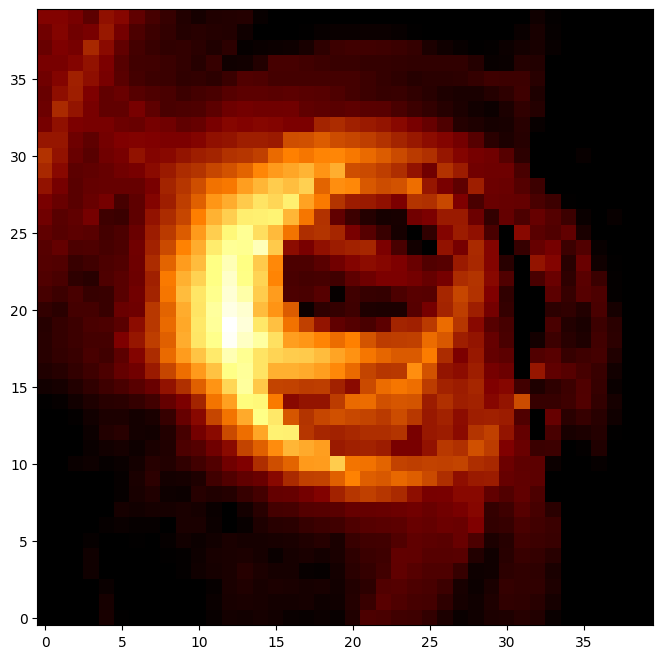

In [33]:
fig = plt.figure(figsize=(8, 8), facecolor='w')

final_image = final_image / np.max(final_image)

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(np.log10(final_image).T, cmap='afmhot', vmin=-4, vmax=0, origin='lower')

# tests below

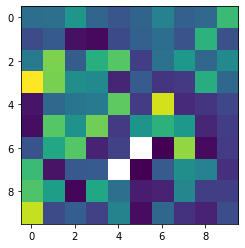

In [228]:
ax1 = plt.subplot(1, 1, 1)

ax1.imshow(tensorial_data['pitch_angle'].min(axis=0).reshape((10, 10)))

In [101]:
from jax import jit, vmap

@jit
def vec_metric(X, bhspin):
    return vmap(mahakala.geodesics.metric, in_axes=(0, None))(X, bhspin)

@jit
def vec_imetric(X, bhspin):
    return vmap(mahakala.geodesics.imetric, in_axes=(0, None))(X, bhspin)

In [102]:
final_M = np.zeros((len(S),len(S[0]),4))
for i in tqdm(range(0,len(S))):
    final_M[i,:,:] = vec_imetric(S[i,:,:4], bhspin)[:,0,:]

100%|██████████| 10001/10001 [00:04<00:00, 2123.72it/s]


In [205]:
xpos_vec = S[:, :, :4]

xs = xpos_vec[:, :, 1]
ys = xpos_vec[:, :, 2]
zs = xpos_vec[:, :, 3]

for j in range(100):
    if np.isnan(np.min(xs[:, j])):
        print(j)
    #print(j, np.min(xs[:, j]))

65
74


In [206]:
len(select_geodesic[:, 0, 1])

419

In [207]:
len(final_dt[:, 64])

10000

In [208]:
tidx = 417
xs[tidx, 65], final_dt[tidx, 65]

(-1.8132638931274414, 0.0)

In [211]:
final_dt[:, 65]

array([-24.96421991, -24.34260941, -23.7364769 , ...,          nan,
                nan,          nan])

(410.0, 425.0)

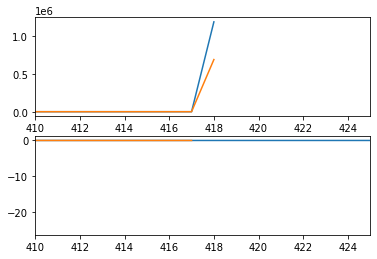

In [232]:
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

ax1.plot(xs[:, 65])
ax2.plot(final_dt[:, 65])
ax1.plot(select_geodesic[:, 0, 1])
ax2.plot(select_dt_final[:, 0])

xlim = [410, 425]

ax1.set_xlim(*xlim)
ax2.set_xlim(*xlim)

In [152]:
select_geodesic.shape

(419, 1, 8)

In [155]:
np.nanmin(select_geodesic[:, 0, 1])

-1.7934848070144653

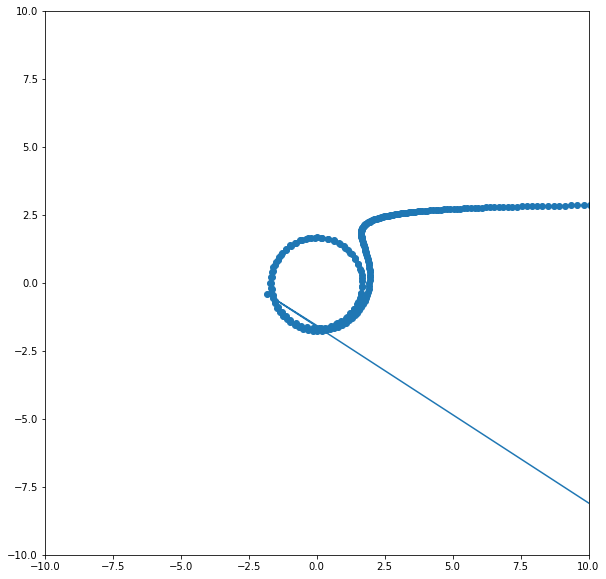

In [233]:
plt.figure(figsize=(10, 10), facecolor='w')

ax1 = plt.subplot(1, 1, 1)

ax1.plot(xs[:, 65], ys[:, 65], '-o')

plim = 10
ax1.set_xlim(-plim, plim)
ax1.set_ylim(-plim, plim)

ax1.set_aspect('equal')

In [142]:
bhspin = 0.9
inclination_in_degrees = 60
distance_in_rg = 1000

fov = 10
number_pixels_across = 10

s0 = ma.initialize_geodesics_at_camera(bhspin, inclination_in_degrees, distance_in_rg, -fov, fov, number_pixels_across)
S, final_dt = ma.geodesic_integrator(10000, s0, 40, 1e-4, bhspin, use_tqdm=True)

100%|██████████| 10000/10000 [00:26<00:00, 371.17it/s]


In [129]:
s0[65]

array([0.00000000e+00, 8.65525391e+02, 3.00000000e+00, 5.00866028e+02,
       1.00000000e+00, 8.62568378e-01, 3.40527458e-06, 4.98003989e-01])

In [133]:
select_geodesic, select_dt_final = ma.geodesic_integrator(10000, np.array([s0[65]]), 40, 1e-4, bhspin, use_tqdm=True)

  4%|▍         | 418/10000 [00:00<00:18, 522.74it/s]


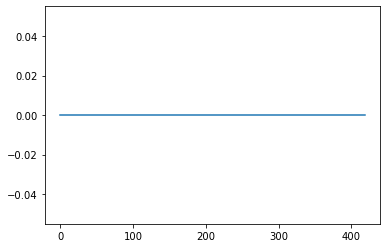

In [137]:
ax1 = plt.subplot(1, 1, 1)

ax1.plot(np.isnan(select_geodesic[:, 0, 1]))

In [139]:
np.min(select_geodesic[:, 0, 1])

-1.7934848070144653

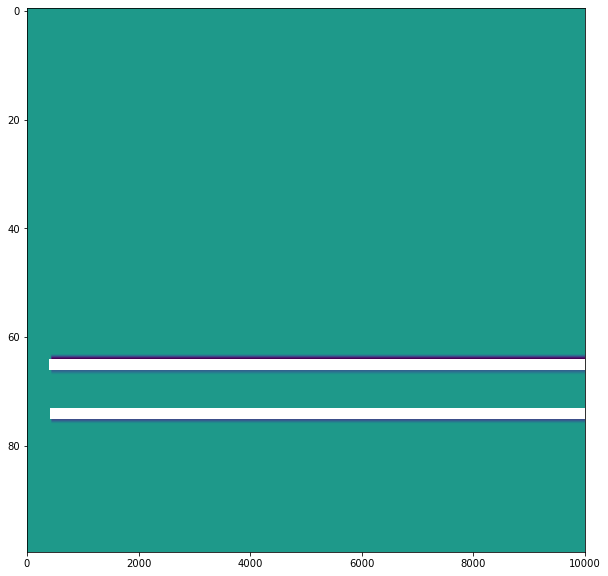

In [234]:
fig = plt.figure(figsize=(10, 10), facecolor='w')

ax1 = plt.subplot(1, 1, 1)

ax1.imshow(xpos_vec[:, :, 0].T)
ax1.set_aspect('auto')

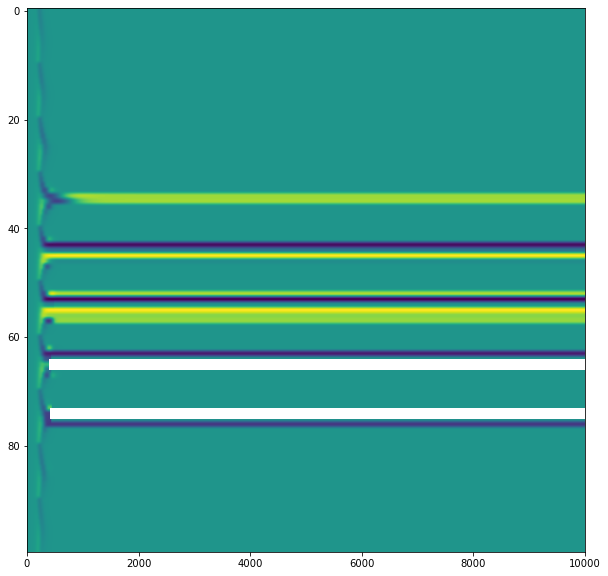

In [106]:
fig = plt.figure(figsize=(10, 10), facecolor='w')

ax1 = plt.subplot(1, 1, 1)

ax1.imshow(final_M[:, :, 3].T)
ax1.set_aspect('auto')

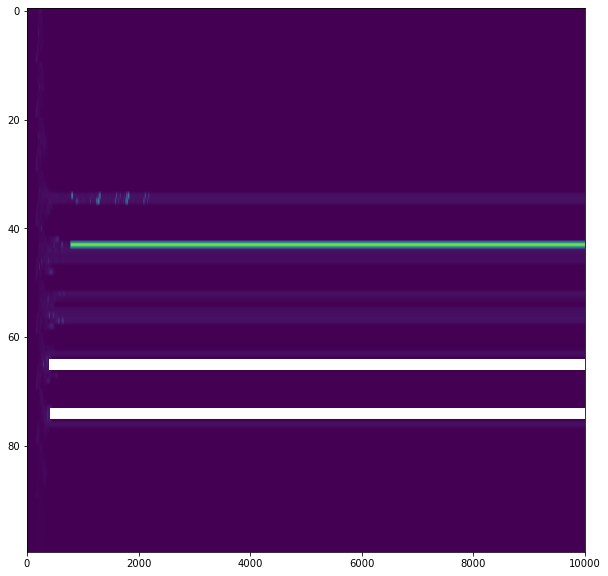

In [95]:
fig = plt.figure(figsize=(10, 10), facecolor='w')

ax1 = plt.subplot(1, 1, 1)

ax1.imshow(tensorial_data['ucon'][0].T)
ax1.set_aspect('auto')

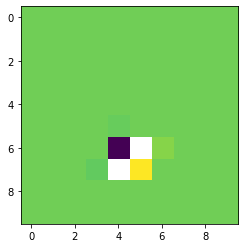

In [76]:
ax1 = plt.subplot(1, 1, 1)

ax1.imshow(local_nu.sum(axis=0).reshape((10, 10)))

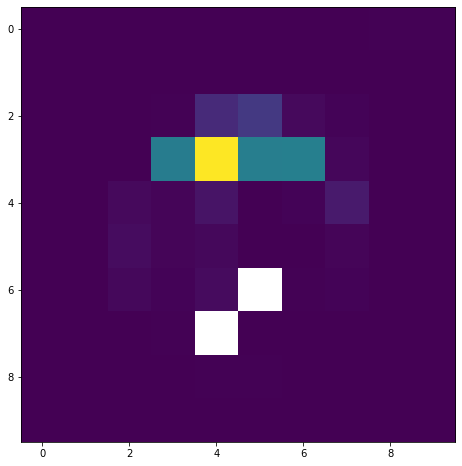

In [ ]:

        Mass_scale = 5e+24

        bfield = np.sqrt(BuBu) *  c * np.sqrt(pow(G*M_BH/c**2,-3) * Mass_scale * 4 * np.pi)

        ne_data = Mass_scale * densff_data * pow(G*M_BH/c**2,-3)  * 1/(1.67 * 1e-24 +  9.1094 * 1e-28)

        R_imp = ((R_high * (beta_data)**2/(1 + (beta_data)**2)) + 1/(1+(beta_data)**2))

        t_electron = c**2 * (m_p  * internal_u_data * (4/3 -1) * (5/3-1))/(Kb * densff_data * ((5/3-1) + (4/3-1) * R_imp))

        thetae = Kb * t_electron/(m_e*c**2)

        #index = np.where(np.isnan(t_electron)== True)
        #t_electron[index[0],index[1]] = 0

        del R_imp

        synemiss_data = np.empty((len(S),LEN))

        for i in range(len(S)):
            synemiss_data[i,:] = synemiss(ne_data[i,:], t_electron[i,:],bfield[i,:],nu[i,:],beta_data[i,:], observer_angle[i,:])

        index = np.where(np.isnan(synemiss_data)==True)
        synemiss_data[index[0],index[1]] = 0.0

        del index
        absorption_data   = np.zeros((len(S), LEN))

        #for i in range(len(S)):
        #    absorption_data[i,:] = absorption_coeff(t_electron[i,:], synemiss_data[i,:], nu[i,:],beta_data[i,:])



        index = np.where(np.isnan(absorption_data)==True)
        absorption_data[index[0],index[1]] = 0.0

        del index

        grav_synchrotron = synemiss_data/nu**2

        index = np.where(np.isnan(grav_synchrotron) == True)

        grav_synchrotron[index[0],index[1]] = 0.0


        index = np.where(np.isnan(gamma_inv_data) == True)
        gamma_inv_data[index[0],index[1]] = 0.0


        index = np.where(sigma_data > 1)
        ne_data[index[0],index[1]] = 0.0
        grav_synchrotron[index[0],index[1]] = 0.0
        absorption_data[index[0],index[1]] = 0.0
        synemiss_data[index[0],index[1]] = 0.0

        index = np.where(nu < 0)
        nu[index[0],index[1]] = 0.0

        index = np.where(grav_synchrotron < 0)
        grav_synchrotron[index[0],index[1]] = 0.0

        index = np.where(absorption_data < 0)
        absorption_data[index[0],index[1]] = 0.0

        N = len(S)

        final_I,I_list = specific_intensity(N,synemiss_data,absorption_data,nu,KuUu,final_dt)


In [45]:
local_nu = -tensorial_data['kdotu'] * 230e9
gamma_inv_data = local_nu / 230.e9

"""
beta_data       = internal_u_data/BuBu * (((fluid_gamma) - 1)/0.5)
sigma_data      = BuBu/densff_data

index = np.where(np.isnan(beta_data) == True)
beta_data[index[0],index[1]] = 0
index = np.where(np.isnan(sigma_data) == True)
sigma_data[index[0],index[1]] = 0    """

In [ ]:

    beta_data       = internal_u_data/BuBu * (((fluid_gamma) - 1)/0.5)
    sigma_data      = BuBu/densff_data

    index = np.where(np.isnan(beta_data) == True)
    beta_data[index[0],index[1]] = 0
    index = np.where(np.isnan(sigma_data) == True)
    sigma_data[index[0],index[1]] = 0

    #return S,ne_data,thetae,bfield_data_pmag,num.sqrt(BuBu),sigma_data,beta_data,-KuUu * 230e9

    def pitch_angle(KuUu,KuBu,BuBu):

        angle = KuBu/(abs(KuUu) * np.sqrt(BuBu))

        index = np.where(BuBu == 0)
        angle[index[0],index[1]] = np.cos(np.pi/2)

        index = np.where(abs(angle) > 1.0)
        angle[index[0],index[1]] = angle[index[0],index[1]]/abs(angle[index[0],index[1]])

        return np.arccos(angle)

    observer_angle = pitch_angle(KuUu,KuBu,BuBu)

    del KuBu

    nu = -KuUu * 230e9

    gamma_inv_data = nu/230e9


    R_high_list = [80]

    for R_high in R_high_list:

        Mass_scale = 5e+24

        bfield = np.sqrt(BuBu) *  c * np.sqrt(pow(G*M_BH/c**2,-3) * Mass_scale * 4 * np.pi)

        ne_data = Mass_scale * densff_data * pow(G*M_BH/c**2,-3)  * 1/(1.67 * 1e-24 +  9.1094 * 1e-28)

        R_imp = ((R_high * (beta_data)**2/(1 + (beta_data)**2)) + 1/(1+(beta_data)**2))

        t_electron = c**2 * (m_p  * internal_u_data * (4/3 -1) * (5/3-1))/(Kb * densff_data * ((5/3-1) + (4/3-1) * R_imp))

        thetae = Kb * t_electron/(m_e*c**2)

        #index = np.where(np.isnan(t_electron)== True)
        #t_electron[index[0],index[1]] = 0

        del R_imp

        synemiss_data = np.empty((len(S),LEN))

        for i in range(len(S)):
            synemiss_data[i,:] = synemiss(ne_data[i,:], t_electron[i,:],bfield[i,:],nu[i,:],beta_data[i,:], observer_angle[i,:])

        index = np.where(np.isnan(synemiss_data)==True)
        synemiss_data[index[0],index[1]] = 0.0

        del index
        absorption_data   = np.zeros((len(S), LEN))

        #for i in range(len(S)):
        #    absorption_data[i,:] = absorption_coeff(t_electron[i,:], synemiss_data[i,:], nu[i,:],beta_data[i,:])



        index = np.where(np.isnan(absorption_data)==True)
        absorption_data[index[0],index[1]] = 0.0

        del index

        grav_synchrotron = synemiss_data/nu**2

        index = np.where(np.isnan(grav_synchrotron) == True)

        grav_synchrotron[index[0],index[1]] = 0.0


        index = np.where(np.isnan(gamma_inv_data) == True)
        gamma_inv_data[index[0],index[1]] = 0.0


        index = np.where(sigma_data > 1)
        ne_data[index[0],index[1]] = 0.0
        grav_synchrotron[index[0],index[1]] = 0.0
        absorption_data[index[0],index[1]] = 0.0
        synemiss_data[index[0],index[1]] = 0.0

        index = np.where(nu < 0)
        nu[index[0],index[1]] = 0.0

        index = np.where(grav_synchrotron < 0)
        grav_synchrotron[index[0],index[1]] = 0.0

        index = np.where(absorption_data < 0)
        absorption_data[index[0],index[1]] = 0.0

        N = len(S)

        final_I,I_list = specific_intensity(N,synemiss_data,absorption_data,nu,KuUu,final_dt)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/I_inv_{}_SANE/I_trial_{}.npy".format(R_high,lower_limit/8),final_I)

        '''
        I_inv_val = []
        I_len_iteration = []
        j_inv_val = []
        j_len_iteration = []


        for shell_radii_val in range(97):

            shell_index = np.load("/xdisk/chanc/home/anikets/Checking_shell/new_sims/Radius_Shells/Radius_{}/Radii_Shell_i{}_{}.npy".format(lower_limit/8, inclination, shell_radii_val))
            j_inv_sum = sum(grav_synchrotron[shell_index[0], shell_index[1]])

            if len(shell_index[0]) == 0:
                j_inv_avg = 0
            else:
                j_inv_avg = j_inv_sum

            j_len_iteration.append(len(shell_index[0]))
            j_inv_val.append(j_inv_avg)

            shell_index = np.load("/xdisk/chanc/home/anikets/Checking_shell/new_sims/Inv_Radius_Shells/Inv_Radius_{}/Inv_Radii_Shell_i{}_{}.npy".format(lower_limit/8, inclination, shell_radii_val))

            I_inv_sum = sum(I_list[shell_index[0], shell_index[1]])

            if len(shell_index[0]) == 0:
                I_inv_avg = 0
            else:
                I_inv_avg = I_inv_sum

            I_len_iteration.append(len(shell_index[0]))
            I_inv_val.append(I_inv_avg)

        j_inv_val = np.array(j_inv_val)
        j_len_iteration = np.array(j_len_iteration)

        I_inv_val = np.array(I_inv_val)
        I_len_iteration = np.array(I_len_iteration)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/j_inv_{}_SANE/GRMHD_000{}/j_inv_{}_RADIUS_i{}.npy".format(R_high,GRMHD_file, lower_limit/8, inclination), j_inv_val)
            # Now j_inv_val is an array of shape (485,)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/j_inv_{}_SANE/GRMHD_000{}/j_len_iteration_{}_RADIUS_i{}.npy".format(R_high,GRMHD_file,lower_limit/8, inclination),j_len_iteration)


        np.save("/xdisk/chanc/home/anikets/Checking_shell/I_inv_{}_SANE/GRMHD_000{}/I_inv_{}_RADIUS_i{}.npy".format(R_high,GRMHD_file, lower_limit/8, inclination), I_inv_val)
        # Now j_inv_val is an array of shape (485,)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/I_inv_{}_SANE/GRMHD_000{}/I_len_iteration_{}_RADIUS_i{}.npy".format(R_high,GRMHD_file,lower_limit/8, inclination),I_len_iteration)


        '''

        I_inv_val = []
        I_len_iteration = []
        j_inv_val = []
        j_len_iteration = []



        for shell_theta_val in range(89):

            shell_index = np.load("/xdisk/chanc/home/anikets/Checking_shell/new_sims/Theta_Shells/Theta_{}/Theta_Shell_i{}_{}.npy".format(lower_limit/8,inclination,  shell_theta_val))
            j_inv_sum = sum(grav_synchrotron[shell_index[0], shell_index[1]])

            if len(shell_index[0]) == 0:
                j_inv_avg = 0
            else:
                j_inv_avg = j_inv_sum

            j_len_iteration.append(len(shell_index[0]))
            j_inv_val.append(j_inv_avg)


            shell_index = np.load("/xdisk/chanc/home/anikets/Checking_shell/new_sims/Inv_Theta_Shells/Inv_Theta_{}/Inv_Theta_Shell_i{}_{}.npy".format(lower_limit/8, inclination, shell_theta_val))


            I_inv_sum = sum(I_list[shell_index[0], shell_index[1]])

            if len(shell_index[0]) == 0:
                I_inv_avg = 0
            else:
                I_inv_avg = I_inv_sum

            I_len_iteration.append(len(shell_index[0]))
            I_inv_val.append(I_inv_avg)


        j_inv_val = np.array(j_inv_val)
        j_len_iteration = np.array(j_len_iteration)

        I_inv_val = np.array(I_inv_val)
        I_len_iteration = np.array(I_len_iteration)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/j_inv_{}_SANE/GRMHD_000{}/j_trial_inv_{}_THETA_i{}.npy".format(R_high,GRMHD_file, lower_limit/8, inclination), j_inv_val)
            # Now j_inv_val is an array of shape (485,)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/j_inv_{}_SANE/GRMHD_000{}/j_trial_len_iteration_{}_THETA_i{}.npy".format(R_high,GRMHD_file,lower_limit/8, inclination),j_len_iteration)


        np.save("/xdisk/chanc/home/anikets/Checking_shell/I_inv_{}_SANE/GRMHD_000{}/I_trial_inv_{}_THETA_i{}.npy".format(R_high,GRMHD_file, lower_limit/8, inclination), I_inv_val)
        # Now j_inv_val is an array of shape (485,)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/I_inv_{}_SANE/GRMHD_000{}/I_trial_len_iteration_{}_THETA_i{}.npy".format(R_high,GRMHD_file,lower_limit/8, inclination),I_len_iteration)

        del j_inv_val
        del j_len_iteration
        del I_inv_val
        del I_len_iteration


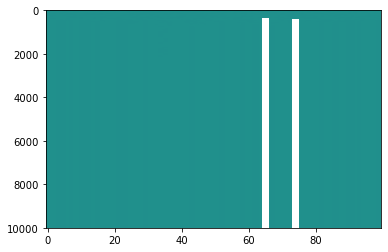

In [39]:
ax = plt.subplot(1, 1, 1)
ax.imshow(tensorial_data['udotu'], vmin=-1.1, vmax=-0.9)
ax.set_aspect('auto')

In [11]:
primitive_data

{'dens': array([[0.00035382, 0.00035143, 0.00034922, ..., 0.0003502 , 0.00034913,
         0.00034809],
        [0.00035363, 0.0003516 , 0.00034957, ..., 0.00035468, 0.00035259,
         0.00035063],
        [0.00036961, 0.00036636, 0.00036316, ..., 0.00036952, 0.000368  ,
         0.00036669],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00010271, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.00010271, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.00010271, 0.        ,
         0.        ]]),
 'u': array([[1.81947625e-07, 1.81436338e-07, 1.80930167e-07, ...,
         1.80517710e-07, 1.80515483e-07, 1.80485449e-07],
        [1.83419867e-07, 1.82482650e-07, 1.81472962e-07, ...,
         1.82362056e-07, 1.81680947e-07, 1.80986693e-07],
        [1.86342759e-07, 1.84656829e-07, 1.82999950e-07, ...,
         1.83183285e-07, 1.82365834e-07, 1.81623227e-07],
        ...,
        [0.00000000e+00

In [ ]:
ne_along_S, B_along_S, ...

In [ ]:

LEN = len(S[0])

h_BL = np.sqrt(1 - a_spin**2)
r_m = 1 - h_BL
r_p = 1 + h_BL



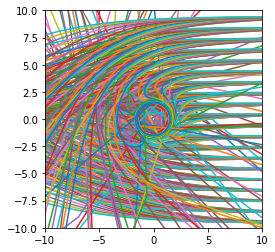

In [15]:
ax1 = plt.subplot(1, 1, 1)

x = S[:, :, 1]
y = S[:, :, 2]
z = S[:, :, 3]

ax1.plot(x, y)

plim = [-10, 10]
ax1.set_xlim(*plim)
ax1.set_ylim(*plim)

ax1.set_aspect('equal')

In [ ]:

LEN = len(S[0])

h_BL = np.sqrt(1 - a_spin**2)
r_m = 1 - h_BL
r_p = 1 + h_BL

densff_data     = np.zeros((len(S),LEN))
B_1_data        = np.zeros((len(S),LEN))
B_2_data        = np.zeros((len(S),LEN))
B_3_data        = np.zeros((len(S),LEN))
U_1_data        = np.zeros((len(S),LEN))
U_2_data        = np.zeros((len(S),LEN))
U_3_data        = np.zeros((len(S),LEN))
internal_u_data = np.zeros((len(S),LEN))

populated = np.zeros((len(S), LEN))
prims = np.zeros((len(S), LEN, 8))

for mbi in tqdm(mb_index_map.values()):

    if mbi < nstart or mbi >= nend:
        break

    mb_x1min = x1f[mbi].min()
    mb_x1max = x1f[mbi].max()
    mb_x2min = x2f[mbi].min()
    mb_x2max = x2f[mbi].max()
    mb_x3min = x3f[mbi].min()
    mb_x3max = x3f[mbi].max()

    mb_mask = (mb_x1min < S[:,:,1]) & (S[:,:,1] <= mb_x1max)
    mb_mask &= (mb_x2min < S[:,:,2]) & (S[:,:,2] <= mb_x2max)
    mb_mask &= (mb_x3min < S[:,:,3]) & (S[:,:,3] <= mb_x3max)
    mb_mask &= (populated == 0)

    x1e = get_extended(x1v[mbi])
    x2e = get_extended(x2v[mbi])
    x3e = get_extended(x3v[mbi])

    # get meshblock key information
    tlevel = Levels[mbi]
    ti, tj, tk = LogicalLocations[mbi]
    key = tlevel, ti, tj, tk

    if np.count_nonzero(mb_mask) == 0:
        continue


    # create and use the interpolation object
    for nprm in range(nprim_all):
        prm = all_meshblocks[mbi,nprm, :, :, :]
        rgi = RegularGridInterpolator((x1e, x2e, x3e), prm.transpose((2,1,0)),
                                        method=interp_method)

        remapped = rgi((S[:,:,1][mb_mask], S[:,:,2][mb_mask], S[:,:,3][mb_mask]))
        outidx, outval = athenak.map_prim_to_prim(remapped, nprm, variable_names, fluid_params)

        prims[mb_mask, outidx] = outval

    # ensure we don't accidentally overwrite already-populated
    # cells (precision issues?)
    populated[mb_mask] = 1


densff_data     = prims[:,:,0]
internal_u_data = prims[:,:,1]
U_1_data        = prims[:,:,2]
U_2_data        = prims[:,:,3]
U_3_data        = prims[:,:,4]
B_1_data        = prims[:,:,5]
B_2_data        = prims[:,:,6]
B_3_data        = prims[:,:,7]

del prims
del populated

In [ ]:

    #########################
    # We'll now convert these primtive variables into variables actually used by the Synchrotron functions.

    #tgas_data = (pressff_data * c**2 * (m_p + m_e)) /(densff_data * Kb)


    @jit

    def another_metric(x):
        eta = jnp.asarray([[1,0,0],[0,1,0],[0,0,1]])
        a = a_spin
        aa = a * a
        zz = x[3]*x[3]
        kk = 0.5 * (x[1]*x[1] + x[2]*x[2] + zz - aa)
        rr = jnp.sqrt(kk * kk + aa * zz ) + kk
        r = jnp.sqrt(rr)
        f = (2.0 * rr * r)/(rr * rr + aa * zz)
        l = jnp.array([(r * x[1] + a * x[2])/(rr + aa) , (r* x[2] - a * x[1])/(rr + aa) , x[3]/r])
        return eta + f * (l[:,jnp.newaxis] * l[jnp.newaxis,:])


    @jit

    def vec_another_metric(X):
        return vmap(another_metric)(X)



    UuUu = np.zeros((len(S),LEN))

    total_u = np.array([U_1_data,U_2_data,U_3_data])
    total_u = np.transpose(total_u, (1,2,0))

    for i in tqdm(range(len(S))):
        UuUu[i,:] = ((vec_metric(S[i,:,:4])[:,1:,1:] @ total_u[i,:,:].reshape(LEN,3,1)).reshape(LEN,1,3) @ total_u[i,:,:].reshape(LEN,3,1)).reshape(LEN)
    del total_u

    GAMMA = np.sqrt(1 + UuUu)

    del UuUu

    final_M = np.zeros((len(S),LEN,4))
    for i in tqdm(range(0,len(S))):

        final_M[i,:,:] = vec_imetric(S[i,:,:4])[:,0,:]

    u0_data = (GAMMA/pow(-final_M[:,:,0],-1/2))
    u1_data = (U_1_data - (final_M[:,:,1] * GAMMA * pow(-final_M[:,:,0],-1/2)))
    u2_data = (U_2_data - (final_M[:,:,2] * GAMMA * pow(-final_M[:,:,0],-1/2)))
    u3_data = (U_3_data - (final_M[:,:,3] * GAMMA * pow(-final_M[:,:,0],-1/2)))



    del final_M

    #######################
    # Now, for the magnetic field components

    BuUu = np.zeros((len(S),LEN))

    total_B = np.array([B_1_data,B_2_data,B_3_data])
    total_B = np.transpose(total_B, (1,2,0))

    total_u = np.array([u0_data,u1_data,u2_data,u3_data])
    total_u = np.transpose(total_u, (1,2,0))

    for i in tqdm(range(len(S))):

        BuUu[i,:] = ((vec_metric(S[i,:,:4]) @ total_u[i,:,:].reshape(LEN,4,1)).reshape(LEN,1,4)[:,:,1:] @ total_B[i,:,:].reshape(LEN,3,1)).reshape(LEN)

    del total_B
    del total_u

    B0_data = BuUu
    del BuUu
    B1_data = 1/u0_data * (B_1_data + B0_data * u1_data)
    B2_data = 1/u0_data * (B_2_data + B0_data * u2_data)
    B3_data = 1/u0_data * (B_3_data + B0_data * u3_data)
